In [1]:
from lib.Base64 import path_to_base64
from skimage import io
import numpy as np
#from PIL import Image
import cv2
import mediapipe as mp
#from segment_anything 
from lib.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import json
import matplotlib.pyplot as plt
import sys



sys.path.append("..")
sam_checkpoint = f"{os.path.abspath(os.getcwd())}/lib/sam_vit_h_4b8939.pth"
model_type = "default"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(
    device='cuda'
    )

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=None,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,
    point_grids=[[[0.5,0.5]],[[0.4,0.5]],[[0.6,0.5]]])

ModuleNotFoundError: No module named 'lib.Base64'

In [20]:
class SMILE:
    def __init__(self,input_path,out_dir):
        self.input_path=input_path 
        self.out_dir=out_dir


        img=io.imread(input_path)
        h, w ,d= img.shape
        self.img=cv2.resize(img, (1024, int(1024*h/w)), interpolation=cv2.INTER_AREA)
        self.img=cv2.cvtColor(self.img,cv2.COLOR_RGB2BGR)
        self.shape=self.img.shape

        self.mouse=[]
        self.box=[]
        self.boximg=[]
        self.box_pol=[]
        self.result=[]

        
        
        self.cuted=[]


        self.grid_len=10###
        self.grid=[]


        self.mask={}
        self.out_path=out_dir
        self.output=f"output.{input_path.split('.')[-1]}"
        self.base64=''

        pass

    def set_predictor(self):
        try:
            self.box[1]
        except:
            self.find_mouse()
        predictor.set_image(self.boximg)
    
    def predict(point):
        masks, scores, logits = predictor.predict(
        point_coords=np.array(point),
        point_labels=np.array([1]*len(point)),
        multimask_output=True,
        )
        sorted_mask = sorted(list(zip(masks, scores)), key=(lambda x: x[1]), reverse=True)
        mask=sorted_mask[0][0]
        mask=np.array(mask, dtype='uint8')

        #plt.imshow(self.boximg)
        #show_mask(mask[0], plt.gca())
        #plt.axis('off')
        #plt.savefig(self.output)
        #self.base64=path_to_base64(self.output)

        contours, hierarchy = cv2.findContours(mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        pol=contours[0].reshape(-1,2)



    
        return pol,f'{sorted_mask[0][1]:.3f}'
    

    
        
        

    """def gen_mask(self):
        try:
            self.box[1]
        except:
            self.find_mouse()
        
        self.masks = mask_generator.generate(self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5])
        self.masks  = sorted(self.masks , key=(lambda x: x['area']), reverse=True)"""



    def cut(self, pol):
        pol=np.array([pol], np.int32)
        #遮片
        mask=np.zeros(self.img.shape[:2], np.uint8)
        #多邊形填上白色
        cv2.polylines(mask, [pol], isClosed=True,color=(255,255,255), thickness=1)
        cv2.fillPoly(mask,pol,255)

        

        
        dst=cv2.bitwise_and(self.img, self.img, mask=mask)
        return dst
    
    def gen_grid(self, pol):
        pol=np.array([pol], np.int32)
        mask=np.zeros(self.img.shape[:2], np.uint8)
        #多邊形填上白色
        cv2.polylines(mask, [pol], isClosed=True,color=(255,255,255), thickness=1)
        cv2.fillPoly(mask,pol,255)

        print('grid')

        for i in range(self.shape[0])[::self.grid_len]:
            for j in range(self.shape[1])[::self.grid_len]:
                if mask[i][j]!=0:
                    self.grid.append([j,i])
    
    def find_mouse(self):
        h, w, d = self.img.shape
        mp_face_detection = mp.solutions.face_detection
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh=mp_face_mesh.FaceMesh(
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2)
    #嘴巴
        mouse=[62,96,89,179,86,15,316,403,319,325,292,407,272,271,268,12,38,41,42,183]
        lip=[78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,13,82,81,80,191]#嘴唇
    
        #########################openCV辨識嘴 #########################
        RGBim = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(RGBim)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                #for index in mouse:
                for index in lip:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    self.mouse.append([x,y])
        self.mouse=np.array(self.mouse)

        self.gen_grid(self.mouse)
        
        """mousep_b=[]
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for index in mouse:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    mousep_b.append([x,y])
        mousep_b=np.array(mousep_b)"""

        
        #找 marker
        umos=min(self.mouse[:,1])#嘴上緣
        dmos=max(self.mouse[:,1])#嘴下緣
        lmos=min(self.mouse[:,0])#嘴左緣
        rmos=max(self.mouse[:,0])#嘴右緣
        wmos=rmos-lmos#嘴寬
        hmos=dmos-umos#嘴高
        mmos=[int((lmos+rmos)/2),int((umos+dmos)/2)]#嘴中心

        self.box=np.array([lmos,rmos,umos,dmos])
        self.boximg=self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5]
        self.box_pol=[self.box[0]-5,self.box[2]-5]

        cv2.imwrite(self.output
                    ,self.boximg)
        self.base64=path_to_base64(self.output)

        
        
        
        ##self.cuted=self.cut( self.mouse)
        
        return self.box
    
    def show_box(self):
        path=f"{self.out_dir}/{self.input_path.split('/')[-1]}"

        cv2.imwrite(path
                    ,self.boximg)
        return path_to_base64(path)
    



    def show_anns(self):
        import matplotlib.pyplot as plt

        if len(self.masks) == 0:
            return

        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        figsize=self.box[1]-self.box[0]
        for ann in self.mask:
            #print(ann)
            if (ann['area']>figsize/10) ^ (ann['area']<figsize/200):
                continue

            
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.35)))
        plt.axis('off')

        path=f"{self.out_dir}/ooouuuttt{self.input_path.split('.')[-1]}"
        plt.savefig(path)
        return path_to_base64(path)
        #plt.show()




def SMILE_0(path):
    ########圖像處理########
    def cut(img, pol):
        pol=np.array([pol], np.int32)
        #遮片
        mask=np.zeros(img.shape[:2], np.uint8)
        #多邊形填上白色
        cv2.polylines(mask, [pol], isClosed=True,color=(255,255,255), thickness=1)
        cv2.fillPoly(mask,pol,255)
        
        dst=cv2.bitwise_and(img, img, mask=mask)
        return dst


    img=io.imread(path)
    h, w ,d= img.shape
    img=cv2.resize(img, (1000, int(1000*h/w)), interpolation=cv2.INTER_AREA)
    pol=np.array([[110,200],[300,400],[160,50]])
    #pol= np.array([[200, 200], [300, 100], [300, 200], [200, 200], [200, 250]], np.int32)
    img=cut(img,pol)



    result = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #######輸出#####
    out_path='output.jpg'
    cv2.imwrite(out_path, img)
    
    
    
    return path_to_base64(out_path)
    #return 'a'    
    


In [22]:

filename = "upload_fig/{}.{}".format('input', 'png')

nowfig=SMILE(filename,'output' )
nowfig.find_mouse()
nowfig.set_predictor()
#nowfig.predict()

grid


In [23]:
arr=np.array([[50.8,14]])
pol,sc=SMILE.predict([[50,14]])

{'Pol':pol, 'sc':sc}

{'Pol': array([[ 67,   0],
        [ 66,   1],
        [  0,   1],
        [  0,  71],
        [  1,  72],
        [  2,  71],
        [109,  71],
        [110,  72],
        [115,  72],
        [116,  71],
        [117,  72],
        [121,  72],
        [122,  71],
        [123,  72],
        [127,  72],
        [128,  71],
        [130,  71],
        [131,  72],
        [135,  72],
        [136,  71],
        [144,  71],
        [145,  72],
        [146,  71],
        [147,  71],
        [148,  72],
        [150,  72],
        [151,  71],
        [172,  71],
        [173,  72],
        [176,  72],
        [177,  71],
        [178,  71],
        [179,  72],
        [181,  72],
        [182,  71],
        [193,  71],
        [194,  72],
        [195,  72],
        [196,  71],
        [197,  72],
        [199,  72],
        [200,  71],
        [202,  71],
        [203,  72],
        [204,  71],
        [263,  71],
        [263,   1],
        [257,   1],
        [256,   0],
        [252,

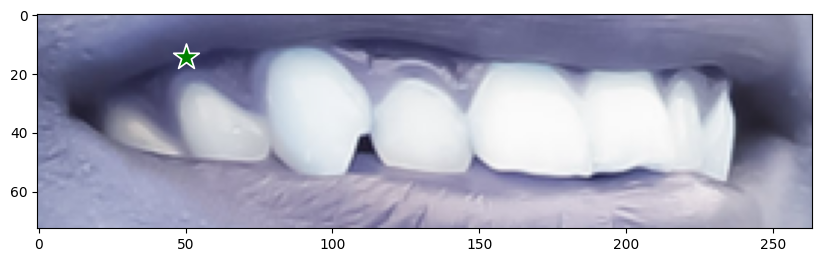

In [24]:
input_point=np.array([[50, 14]])
input_label=np.array([1])
def show_points(coords, labels, ax, marker_size=375):
    labels=np.array(labels)
    pos_points = np.array(coords[labels==1])
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

plt.figure(figsize=(10,10))
plt.imshow(nowfig.boximg)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

1.0011302 0.13257575757575757
0.99378544 0.13257575757575757
0.99906284 0.13257575757575757
0.98871034 0.11363636363636363
0.9991131 0.13257575757575757
0.9922629 0.13257575757575757
0.99050575 0.13257575757575757
1.0021324 0.13257575757575757
0.9998439 0.125
0.99434966 0.125
0.9943412 0.1553030303030303
0.9940503 0.1553030303030303
0.99646825 0.1553030303030303
0.9986338 0.1553030303030303
0.9782157 0.10984848484848485
0.97489053 0.10984848484848485
0.9745553 0.10984848484848485
0.95338184 0.045454545454545456
0.9659692 0.09848484848484848
0.9826974 0.11363636363636363
0.9809808 0.11363636363636363
0.9779906 0.11363636363636363
1.0035216 0.13257575757575757
0.9923337 0.13257575757575757
0.9904071 0.13257575757575757
0.9971569 0.13257575757575757
0.98795664 0.125
0.98735267 0.125
0.9859125 0.125
0.9926085 0.1553030303030303
0.9967722 0.1553030303030303
0.99960834 0.1553030303030303
1.0028515 0.1553030303030303
0.9832954 0.10984848484848485
0.97968477 0.10984848484848485
0.9759302 0.109

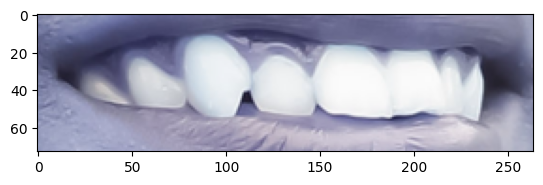

In [25]:
#from lib.PolygonSet import PolygonSet
plt.imshow(nowfig.boximg)

grid=np.array([pt-nowfig.box_pol for pt in np.array(nowfig.grid)])

def mask_to_pol(mask):
    mask=np.array(mask, dtype='uint8')

    contours, hierarchy = cv2.findContours(mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    h,w=mask.shape

    pol=contours[0].reshape(-1,2)
    #pol=[ [round(p[0]/w,3),round(p[1]/h,3)]  for p in pol]
    return np.array(pol)

def polygon_area(points):
    area = 0
    q = points[-1]
    for p in points:
        area += p[0] * q[1] - p[1] * q[0]
        q = p
    return int(abs(area / 2))


tooth=PolygonSet()

for pt in grid:
    

    masks, scores, logits = predictor.predict(
        point_coords=np.array([pt]),
        point_labels=np.array([1]),
        multimask_output=True,
    )
    
    for mask,score in zip(masks, scores):
        pp=mask_to_pol(mask)

        if score<0.95:
            continue

        if (max(pp[:,0])-min(pp[:,0]))/nowfig.boximg.shape[1]>0.2:
            continue

        if nowfig.boximg.shape[0]*nowfig.boximg.shape[1]/300>polygon_area(pp):
            continue


        print(score,(max(pp[:,0])-min(pp[:,0]))/nowfig.boximg.shape[1])
        tooth.append(pp)
        
        """plt.imshow(nowfig.boximg)
        show_points(np.array([pt]), [1], plt.gca())
        plt.plot(pp[:,0],pp[:,1])
        #show_mask(mask, plt.gca(),random_color=True)
        plt.axis('on')
        plt.show() """



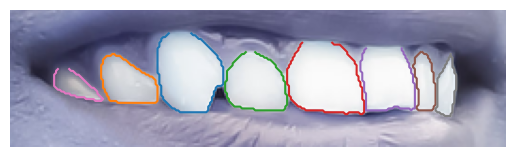

In [18]:
plt.imshow(nowfig.boximg)
for pol in tooth.polygons:
    plt.plot(pol[:,0],pol[:,1])
plt.axis('off')
plt.show()

In [ ]:
nowfig.shape

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(nowfig.boximg)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    show_points(point,[1]*len(point), plt.gca())
    plt.axis('off')
    plt.show()  

In [ ]:
w,h=mask.shape
new=mask.reshape(h, w, 1)*1

color = np.array([30/255, 144/255, 255/255, 0.6])
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.gca().imshow(mask_image)

In [ ]:
mask*1
np.array(mask, dtype='uint8')

In [ ]:
arr=list(zip(masks, scores))
sorted_arr = sorted(arr, key=(lambda x: x[1]), reverse=True)
show_mask(sorted_arr[0][0], plt.gca())

In [ ]:
plt.imshow(mask)
plt.show()

In [ ]:
polygons = []
mask=np.array(mask, dtype='uint8')
contours, hierarchy = cv2.findContours(mask*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


contours[0].reshape(-1,2)



In [ ]:


b  = np.array([[[100,100],  [250,100], [300,220],[100,230]]], dtype = np.int32)

im = np.zeros([100,100], dtype = "uint8")
cv2.polylines(im, b, 1, 255)
cv2.fillPoly(im, b, 255)

mask2 = im


In [ ]:

from typing import Any, Dict, Generator, ItemsView, List, Tuple

def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points
def build_all_layer_point_grids(
    n_per_side: int, n_layers: int, scale_per_layer: int
) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_points = int(n_per_side / (scale_per_layer**i))
        points_by_layer.append(build_point_grid(n_points))
    return points_by_layer

In [ ]:
a=build_all_layer_point_grids(
                30,
                0,
                2,
            )
np.array(a)
a[0][200:230]

In [ ]:
from lib.SMILE import SMILE

filename = "upload_fig/{}.{}".format('input', 'png')

nowfig=SMILE(filename,'output' )
nowfig.find_mouse()
nowfig.set_predictor()
#nowfig.predict()


In [ ]:
SMILE.predict(0.2,0.2)

In [ ]:
pol,sc=SMILE.predict(0.2,0.3)
xpol=','.join([str(i) for i in pol[:,0]])
ypol=','.join([str(i) for i in pol[:,1]])
a={'xpol':xpol, 'ypol':ypol,'sc':sc, 'msg':'success'}
a

In [ ]:
pol[:]

In [ ]:
nowfig.boximg.shape[1]


In [16]:
class PolygonSet:
    def __init__(self):
        self.polygons=[]

    def append(self,pol):
        for e in self.polygons:
            if PolygonSet.isSame(e,pol):
                return
        self.polygons.append(pol)


    def isSame(pol1,pol2):
        def pol_to_mask(pol):
            pol=np.array([pol], np.int32)
            mask=np.zeros([1000,1000], np.uint8)
            cv2.polylines(mask, [pol], isClosed=True,color=1, thickness=1)
            cv2.fillPoly(mask,pol,1)
            return mask
        
        if (np.mean(pol1[:,0])-np.mean(pol2[:,0]))**2+(np.mean(pol1[:,1])-np.mean(pol2[:,1]))**2>18:
            return False
        
        xor=(pol_to_mask(pol1)+pol_to_mask(pol2))%2
        #show_mask(xor)
        return sum(xor.flatten())/(polygon_area(pol1)+polygon_area(pol2))<0.1
    
    def polygon_area(points):
        area = 0
        q = points[-1]
        for p in points:
            area += p[0] * q[1] - p[1] * q[0]
            q = p
        return int(abs(area / 2))
    
    def show_mask(mask):
        w,h=mask.shape
        new=mask.reshape(h, w, 1)*1

        color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        plt.gca().imshow(mask_image)



In [ ]:




PolygonSet.isSame(tooth[3],tooth[1])

In [3]:
from os import listdir
from lib.Base64Converter import path_to_base64
def get():
    dir_path="TrainData/mask/"
    files = listdir(dir_path)
    for f in files:
        if f.split('.')[-1]=="png":
            return {"fig":path_to_base64(f'{dir_path}{f}')}
    """except:
        return {'msg':'超出範圍'}"""
    
get()

{'fig': 'iVBORw0KGgoAAAANSUhEUgAAAREAAABYCAIAAABd1lTJAAAgAElEQVR4AVzBS69taZod5DHG+31z7b3PJS55qaxLIksYCZq2QJQKYbAwWJRcwtgGm39Dgw49Okh06IAQIGH3kIB/YOhhyUJFQVkuZHBkZERGxDl7rzXn947BXDsyqSyeh//h7/5FqapU0mSNKiSx4wBZvQKmqlMNJXG311FYl6ExhlUgChqq06gqqihRAjOdsQgk8GokAty9jnVCcjtut+O27/vaj7QZ0IFToEBR8zJIAiBOJPE9noCoMKdUIn3qdixQr0jOyiioihKIEymSAJLYvmCKSoJXSUjilV9VlVRBENSoBCSlSnwcK+4SVUUyiZMxRhLbSWyjKRDEiQSZ2CBIEyRhbRqjpDhrLQCi2m07jt3wkgpkECeOQwQMAKIirhy9kowqVeUOiXMHjWIJAZBuk6wxCKzViVXCQBLbSZC0DUBSTjYgQEkAJLENIkACx6vX6kVCJRC2A1QViCTHOrx8wUxnuR0baPfqduwEBMx1sOGO7QRZ9lqr3U5ILsQxfomnURUACb7HAwgpgHZsiEXKNiCKgXUqJbBNwDaAUiVpt8CqChICIEsADHTimCaiIA6MGOB/9Hv/olSjVKqSpgpAbDgAjl4BUKM5HIVI0rcrfVyGLtuWsQEoslQnAgyGWFKxMJKt8b2AuLO91jpO63Cy324vz1evBTv74vKkioTBJOXgFYmEJwkngiB4KlWVBBLBOg4AkkiKDE25qqQiAfAEgmBO9sYhKglekawqkgBst0+gBCDJGEOvQMZe3bAFUwIQBIFtAAQCxEZKKBAgiJPjBlFEkRAbRZUox91NEEQSv0pMRBKIBA0v2wRIECErqiOrO4lKqiIYxHYSx6NGVSGxneAkicRaywnFpoPge2QSgCcAnTAYYQBKtvd1mLANMsjtOFbfSFQVSQRJAJSKpGN3T49efaxjre70sle3TzEAh73